<a href="https://colab.research.google.com/github/HRNPH/GANime-FullBody/blob/main/ProGans(shitcode).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model

## Model Components

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import log2

In [ ]:
class WSConv2d(nn.Module):
  def __init__(self, in_channel, out_channel, kernel_size=3, stride=1, padding=1, gain=2):
    super(WSConv2d, self).__init__()
    self.conv = nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding)
    self.scale = (gain / (in_channel * (kernel_size ** 2))) ** 0.5
    self.bias = self.conv.bias
    self.conv.bias = None

    #initializae conv layer
    nn.init.normal_(self.conv.weight)
    nn.init.zeros_(self.bias)

  def forward(self,x):
    return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

In [ ]:
class PixelNorm(nn.Module):
  def __init__(self):
    super(PixelNorm, self).__init__()
    self.epsilon = 1e-8

  def forward(self, x):
    return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True) + self.epsilon)
  pass

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_channel, out_channel, use_pixelnorm=True):
    super(ConvBlock, self).__init__()
    self.conv1 = WSConv2d(in_channel, out_channel)
    self.conv2 = WSConv2d(out_channel, out_channel)
    self.leaky = nn.LeakyReLU(0.2)
    self.pn = PixelNorm()
    self.use_pn = use_pixelnorm

  def forward(self, x, use_pixelnorm=True):
    x = self.leaky(self.conv1(x))
    x = self.pn(x) if self.use_pn else x
    x = self.leaky(self.conv2(x))
    x = self.pn(x) if self.use_pn else x
    return x

## Model Classes

In [ ]:
class Generator(nn.Module):
  def __init__(self, z_dim, in_channel, img_channel=3):
    super(Generator,self).__init__()
    self.initial = nn.Sequential(
        PixelNorm(),
        nn.ConvTranspose2d(z_dim, in_channel, 4, 1, 0),#1x1 -> 4x4
        nn.LeakyReLU(0.2),
        WSConv2d(in_channel, in_channel, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(0.2),
        PixelNorm(),
    )

    self.initial_rgb = WSConv2d(in_channel, img_channel, kernel_size=1, stride=1, padding=0)
    self.prog_blocks, self.rgb_layer = nn.ModuleList([]), nn.ModuleList([self.initial_rgb])

    for i in range(len(factors) - 1):# was declared out of this classes
      conv_in_c = int(in_channel * factors[i])
      conv_out_c = int(in_channel * factors[i + 1])

      self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
      self.rgb_layer.append(WSConv2d(conv_out_c, img_channel, kernel_size=1, stride=1, padding=0))

  def fade_in(self, alpha, upscaled, generated):
    return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

  def forward(self, x, alpha, steps):
    out = self.initial(x)

    if steps == 0:
      return self.initial_rgb(out)
    
    for step in range(steps):
      upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
      out = self.prog_blocks[step](upscaled) # use procbloc number STEP as a function for UPSCALED "OUT"
    
    final_upscaled = self.rgb_layer[steps - 1](upscaled)
    final_out = self.rgb_layer[steps](out)
    return self.fade_in(alpha, final_upscaled, final_out)


In [ ]:
from torch.nn.modules.activation import LeakyReLU
class Discriminator(nn.Module):
  def __init__(self, in_channel, img_channel=3):
    super(Discriminator,self).__init__()
    
    self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
    self.Leaky = nn.LeakyReLU(0.2)

    for i in range(len(factors) - 1, 0, -1):
      conv_in_c = int(in_channel * factors[i])
      conv_out_c = int(in_channel * factors[i - 1])     
      self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c, use_pixelnorm=False))
      self.rgb_layers.append(WSConv2d(img_channel, conv_in_c, kernel_size=1, stride=1, padding=0))

    self.initial_rgb = WSConv2d(img_channel, in_channel, kernel_size=1, stride=1, padding=0)
    self.rgb_layers.append(self.initial_rgb)
    self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)

    #block for 4x4 resolution
    self.final_block =  nn.Sequential(
        WSConv2d(in_channel + 1, in_channel, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(0.2),
        WSConv2d(in_channel, in_channel, kernel_size=4, stride=1, padding=0),
        nn.LeakyReLU(0.2),
        WSConv2d(in_channel, 1, kernel_size=1, stride=1, padding=0),
    )

  def fade_in(self, alpha, downscaled, out):
    return alpha * out + (1 - alpha) * downscaled

  def minibatch_std(self, x):
    batch_statistics = torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
    return torch.cat([x, batch_statistics], dim=1)

  def forward(self, x, alpha, step):
    cur_step = len(self.prog_blocks) - step
    out = self.Leaky(self.rgb_layers[cur_step](x))

    if step == 0:
      
      out = self.minibatch_std(out)
      return self.final_block(out).view(out.shape[0], -1)

    downscaled = self.Leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
    out = self.avg_pool(self.prog_blocks[cur_step](out))
    out = self.fade_in(alpha, downscaled, out)

    for step in range(cur_step + 1, len(self.prog_blocks)):
      out = self.prog_blocks[step](out)
      out = self.avg_pool(out)

    out = self.minibatch_std(out)
    return self.final_block(out).view(out.shape[0], -1)

# Train

## Library

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from torch.utils import tensorboard
from math import log2
from tqdm import tqdm

import matplotlib.pyplot as plt
import torchvision
import numpy as np
import random
import torch
import cv2
import os


## Config & Utils

### Config

In [ ]:

class configure():
  def __init__(self):
    self.START_TRAIN_AT_IMG_SIZE = 4
    self.DATASET = '/content/drive/MyDrive/Datasets/resized_ganime_fullbody_cleaned_ds/'
    self.DATASET_type = 'img' #numpy, img
    self.CHECKPOINT_GEN = "/content/drive/MyDrive/Datasets/save/128x128_progans_fullbody/working/gen.pth"
    self.CHECKPOINT_DIS = "/content/drive/MyDrive/Datasets/save/128x128_progans_fullbody/working/dis.pth"
    self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    self.SAVE_MODEL = True
    self.LOAD_MODEL = False
    self.LEARNING_RATE = 1e-8
    self.ALPHA = 1e-5
    self.BETAS = (0.0, 0.99)
    self.BATCH_SIZES = [16, 16, 16, 8, 8, 8, 8, 4, 2]
    self.CHANNELS_IMG = 3
    self.Z_DIM = 1024  # should be 512 in original paper
    self.IN_CHANNELS = 1028  # should be 512 in original paper
    self.CRITIC_ITERATIONS = 1
    self.LAMBDA_GP = 10
    self.PROGRESSIVE_EPOCHS = [30] * len(self.BATCH_SIZES)
    self.FIXED_NOISE = torch.randn(8, self.Z_DIM, 1, 1).to(self.DEVICE)
    self.NUM_WORKERS = 4
    self.SEED = 0

config = configure()
visualize_noise = torch.randn(16, config.IN_CHANNELS, device=config.DEVICE, dtype=torch.float) #don't touch this noise since we're using it for visualizations

In [ ]:
# factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32] 
factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8] # for 256x256

### Utils

In [ ]:
def plotter(data):
  data = torch.moveaxis(data*127.5+127.5,1,-1).numpy().astype(int)
  fig,ax = plt.subplots(2,2,figsize=(5,5))
  for i in range(2):
    for j in range(2):
      ax[i,j].imshow(data[i+2*j])
      ax[i,j].axis('off')
  plt.show()

In [ ]:
def random_sample(data):
  for images in data:
    for img in images:
      print(images.shape)
      img = np.transpose(img.numpy(), (1, 2, 0))
      print(img.shape)
      plt.imshow(img)
      
      break
    break

In [ ]:
def set_seed(seed):
    seed = config.SEED
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [ ]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

In [ ]:
# Print losses occasionally and print to tensorboard
def plot_to_tensorboard(
    writer, loss_critic, loss_gen, real, fake, tensorboard_step
):
    writer.add_scalar("Loss Critic", loss_critic, global_step=tensorboard_step)

    with torch.no_grad():
        # take out (up to) 8 examples to plot
        img_grid_real = torchvision.utils.make_grid(real[:8], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:8], normalize=True)
        writer.add_image("Real", img_grid_real, global_step=tensorboard_step)
        writer.add_image("Fake", img_grid_fake, global_step=tensorboard_step)

## Setup

### Data Loader

In [ ]:
def dataloader(size,batch_size):
  np_array = []
  loader_size = None

  if config.DATASET_type == 'img':
    print(f'Loading Data at size {size}...')
    for image in tqdm(os.listdir(config.DATASET)):
      img_path = config.DATASET + image
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      to_size = (size,size)
      img = cv2.resize(img,to_size)
      np_array.append(img)

  np_array = np.array(np_array)/127.5-1
  loader_size = np_array.shape[0]#number of images

  temp0 = np.moveaxis(np_array,-1,1)[0:]#[0:x] -> x = limit of datasets
  del np_array
  temp = torch.tensor(temp0).float()
  del temp0
  train_loader = torch.utils.data.DataLoader(temp, 
                                           batch_size=batch_size, 
                                           num_workers=config.NUM_WORKERS, 
                                           shuffle=True,
                                           )
  del temp

  return train_loader, loader_size

### loss & all

In [ ]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

### Trainer

In [ ]:
def trainer(
    critic,
    gen,
    loader,
    data_len,
    step,
    alpha,
    opt_critic,
    opt_gen,
    tensorboard_step,
    writer,
    scaler_gen,
    scaler_critic,
):
    loop = tqdm(loader, leave=True)
    for batch_idx, real in enumerate(loop):
        real = real.to(config.DEVICE)
        cur_batch_size = real.shape[0]

        
        

        # Train Critic: max E[critic(real)] - E[critic(fake)] <-> min -E[critic(real)] + E[critic(fake)]
        # which is equivalent to minimizing the negative of the expression
        noise = torch.randn(cur_batch_size, config.Z_DIM, 1, 1).to(config.DEVICE)

        with torch.cuda.amp.autocast():
            fake = gen(noise, alpha, step)
            critic_real = critic(real, alpha, step)
            critic_fake = critic(fake.detach(), alpha, step)
            gp = gradient_penalty(critic, real, fake, alpha, step, device=config.DEVICE)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake))
                + config.LAMBDA_GP * gp
                + (0.001 * torch.mean(critic_real ** 2))
            )

        opt_critic.zero_grad()
        scaler_critic.scale(loss_critic).backward()
        scaler_critic.step(opt_critic)
        scaler_critic.update()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        with torch.cuda.amp.autocast():
            gen_fake = critic(fake, alpha, step)
            loss_gen = -torch.mean(gen_fake)

        opt_gen.zero_grad()
        scaler_gen.scale(loss_gen).backward()
        scaler_gen.step(opt_gen)
        scaler_gen.update()

        # Update alpha and ensure less than 1
        alpha += cur_batch_size / (
            (config.PROGRESSIVE_EPOCHS[step] * 0.5) * data_len
        )
        alpha = min(alpha, 1)

        if batch_idx % 100 == 0:
            with torch.no_grad():
                fixed_fakes = gen(config.FIXED_NOISE, alpha, step) * 0.5 + 0.5
            plot_to_tensorboard(
                writer,
                loss_critic.item(),
                loss_gen.item(),
                real.detach(),
                fixed_fakes.detach(),
                tensorboard_step,
            )
            tensorboard_step += 1

            plotter(fixed_fakes.detach().cpu())

        loop.set_postfix(
            gp=gp.item(),
            loss_gen=loss_gen.item(),
            loss_dis=loss_critic.item(),
        )

    return tensorboard_step, alpha

## Train

### Model Init

In [ ]:
#optimizers
seed_size = config.Z_DIM
in_channels = config.IN_CHANNELS
device = torch.device(config.DEVICE)

gen = Generator(seed_size, in_channels)
dis = Discriminator(in_channels)

gen.to(device)
dis.to(device)

gen_optimizer = torch.optim.Adam(
    dis.parameters(), lr=config.LEARNING_RATE, betas=config.BETAS
)
dis_optimizer = torch.optim.Adam(
    dis.parameters(), lr=config.LEARNING_RATE, betas=config.BETAS
)

dis_scaler = torch.cuda.amp.GradScaler()
gen_scaler = torch.cuda.amp.GradScaler()

#tensorboard plotting
writer = SummaryWriter(f"logs/gan1")

if config.LOAD_MODEL:
  load_checkpoint(
      config.CHECKPOINT_GEN, gen, gen_optimizer, config.LEARNING_RATE
  )
  load_checkpoint(
      config.CHECKPOINT_DIS, dis, dis_optimizer, config.LEARNING_RATE
  )

### Train

In [ ]:
num_epochs = config.PROGRESSIVE_EPOCHS
batch_size = config.BATCH_SIZES
reg_lambda = config.LAMBDA_GP

torch.backends.cudnn.benchmarks = True #idk why they said it improve performance

In [ ]:
#enable traning
gen.train()
dis.train()

tensorboard_step = 0

step = int(log2(config.START_TRAIN_AT_IMG_SIZE / 4))

for num_epochs in config.PROGRESSIVE_EPOCHS[step:]:
  alpha = config.ALPHA
  cur_batch_size = config.BATCH_SIZES[step]
  loader, data_len = dataloader(4*2 ** step, cur_batch_size)

  print(f'Images Size : {4*2 ** step}')

  for epoch in range(num_epochs):
            print(f"Epoch [{epoch+1}/{num_epochs}]")

            tensorboard_step, alpha = trainer(
                dis,
                gen,
                loader,
                data_len,
                step,
                alpha,
                dis_optimizer,
                gen_optimizer,
                tensorboard_step,
                writer,
                gen_scaler,
                dis_scaler,
            )

            if config.SAVE_MODEL:
                # if epoch % 2:#save every 2 epochs
                save_checkpoint(gen, gen_optimizer, filename=config.CHECKPOINT_GEN)
                save_checkpoint(dis, dis_optimizer, filename=config.CHECKPOINT_DIS)

  step += 1  # progress to the next img size


NameError: ignored

## Show Tensorboard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir 'logs/gan1'

# Test

## test model code

In [ ]:
def test_code():
  z_dim = 100
  in_channel = 256
  imgchannel = 3
  gen = Generator(z_dim, in_channel, imgchannel)
  dis = Discriminator(in_channel, imgchannel)

  # for image_size in [4, 8, 16, 32, 64, 128, 256, 512, 1024]:
  for image_size in [4, 8, 16, 32, 64, 128, 256]:
    num_steps = int(log2(image_size / 4))
    x = torch.randn((1, z_dim, 1, 1))
    z = gen(x, 0.5, steps=num_steps)
    assert z.shape == (1, 3, image_size, image_size)
    out = dis(z, alpha=0.5, step=num_steps)
    assert out.shape == (1, 1)
    print(f'Success At Images Size of {image_size}')

In [ ]:
#test_code()

## Test Model Result

In [ ]:
load_checkpoint(
    config.CHECKPOINT_GEN, gen, gen_optimizer, config.LEARNING_RATE
)
load_checkpoint(
    config.CHECKPOINT_DIS, dis, dis_optimizer, config.LEARNING_RATE
)


=> Loading checkpoint
=> Loading checkpoint


In [ ]:
noise = torch.randn(4, config.Z_DIM, 1, 1).to(config.DEVICE)
img_path = config.DATASET
img_path = os.listdir(img_path)

In [ ]:
img_path[0]

'9039.png'

In [ ]:
def test_smallbatch_img(img_path, to_size, num):
  np_array = []
  
  for i in range(num):
    img = cv2.imread(config.DATASET + img_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(to_size,to_size))
    np_array.append(img)

  np_array = np.array(np_array)/127.5-1
  loader_size = np_array.shape[0]#number of images

  temp0 = np.moveaxis(np_array,-1,1)[0:]#[0:x] -> x = limit of datasets
  temp = torch.tensor(temp0).float()
  train_loader = torch.utils.data.DataLoader(temp, 
                                      batch_size=4, 
                                      num_workers=config.NUM_WORKERS,)
  return train_loader

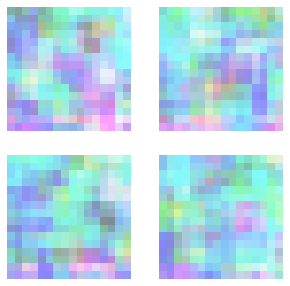

In [ ]:
fake = gen(config.FIXED_NOISE, 0.5, 2) * 0.5 + 0.5
plotter(fake.detach().cpu())

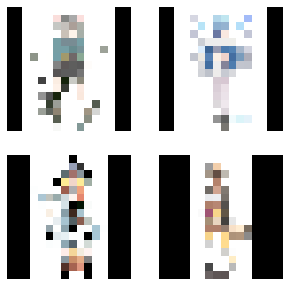

In [ ]:
data = test_smallbatch_img(img_path, 16, 4)
real = None
for image in data:
  real = image
  real = real.cuda()
  plotter(image)


#### Fake Pred

In [ ]:
pred = dis(fake[0:4].detach(), 0.5, 2)

In [ ]:
print(pred)

tensor([[1.0674],
        [1.0293],
        [1.0155],
        [1.0903]], device='cuda:0', grad_fn=<ViewBackward0>)


In [ ]:
real.shape

torch.Size([4, 3, 32, 32])

In [ ]:
predict = dis(real, 0.5, 2)

In [ ]:
print(predict)

tensor([[0.6053],
        [0.4921],
        [0.8547],
        [0.3865]], device='cuda:0', grad_fn=<ViewBackward0>)


In [ ]:
pred.shape

torch.Size([10, 1])